In [1]:
import numpy as np
from os import listdir
from tools.tool import cal_SNR,gmm_defined_analytic,unpack,gmm_predict,find_file,change_label
import pandas as pd
from IPython.display import display
from os import makedirs,listdir,remove
from os.path import exists
import matplotlib.pyplot as plt
import pickle
import time
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

from tools.Load_PYQUM import Load_pyqum
from tools.tool import gmm_analytic,confidence_ellipse_gmm,std_dev,cal_Tmk
import scipy

foldername = r"./data/2Qproba/"
#pyqum_path = find_file(foldername,19)
pyqum_path = find_file(foldername)
pyqum = Load_pyqum(pyqum_path)
print("JOBID: ",pyqum.jobid)
df = pyqum.dataframe
df['I']*=1000
df['Q']*=1000
fq1 = float(pyqum.rjson()['Q1XYF'])
fq2 = float(pyqum.rjson()['Q2XYF'])
df

Pick an option:
1) .DS_Store	2) 2Qstate_1.pyqum	3) 2Qtomo.pyqum	4) 2Qproba_test.pyqum	
Your Choice is 3
./data/2Qproba/2Qtomo.pyqum
Comment : 
Q1,Q2 TOMO 
examine pyqum data
R-JSON :
	 ROSTART  :  40000
	 ROW  :  8000
	 Q1ROL  :  0.08
	 Q2ROL  :  0.085
	 ROF  :  5.934
	 ROdelay  :  280
	 ZW  :  50000
	 Q1Z  :  0.03
	 Q3Z  :  0.12
	 Q2Z  :  -0.01
	 ROSTART,ROdelay,XYW>ROSTART-ROdelay-2*XYW  :  0
	 ROSTART,ROdelay,XYW>ROSTART-ROdelay-XYW  :  0
	 XYW  :  20
	 Q1XYF  :  3.93376
	 Q1XYL  :  0 0.15
	 TOMOL1  :  0 0.075 -0.075
	 Q2XYF  :  4.472
	 Q2XYL  :  0 0.21
	 TOMOL2  :  0 0.105 -0.105
	 TOMOR  :  0 90
IF_ALIGN_MHz:  ['-186.776', '101.2']
RECORD-SUM :  20000
RECORD_TIME_NS :  1500
Change : 
	 ['Q1XYL' 'TOMOL1' 'Q2XYL' 'TOMOL2' 'TOMOR' 'IF_ALIGN_MHz' 'RECORD-SUM']
Change command : 
	 ['0 0.15' '0 0.075 -0.075' '0 0.21' '0 0.105 -0.105' '0 90'
 '-186.776 101.2' '1to20000*19999']


     Q1XYL      :  0.0   to  0.15  *   2  
    TOMOL1      : -0.075 to 0.075  *   3  
     Q2XYL      :  0.0  

,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
0,0.00,0.000,0.00,0.000,0.0,-186.776,1.0,-0.369456,0.135291
1,0.00,0.000,0.00,0.000,0.0,-186.776,2.0,-1.104145,-0.083267
2,0.00,0.000,0.00,0.000,0.0,-186.776,3.0,-0.470663,-0.232801
3,0.00,0.000,0.00,0.000,0.0,-186.776,4.0,-0.203403,-0.222228
4,0.00,0.000,0.00,0.000,0.0,-186.776,5.0,-0.350959,-0.546744
...,...,...,...,...,...,...,...,...,...
2879995,0.15,-0.075,0.21,-0.105,90.0,101.200,19996.0,1.126689,0.563300
2879996,0.15,-0.075,0.21,-0.105,90.0,101.200,19997.0,1.235609,0.481668
2879997,0.15,-0.075,0.21,-0.105,90.0,101.200,19998.0,1.301134,0.544906
2879998,0.15,-0.075,0.21,-0.105,90.0,101.200,19999.0,1.120626,0.327780


In [2]:

def give_plotRange(g_df, e_df):
    xaxis,yaxis = 'I','Q'
    axis0_xrange=np.array([min(g_df[xaxis].min(),e_df[xaxis].min())-max(g_df[xaxis].var(),e_df[xaxis].var()),max(g_df[xaxis].max(),e_df[xaxis].max())+max(g_df[xaxis].var(),e_df[xaxis].var())])
    axis0_yrange=np.array([min(g_df[yaxis].min(),e_df[yaxis].min())-max(g_df[yaxis].var(),e_df[yaxis].var()),max(g_df[yaxis].max(),e_df[yaxis].max())+max(g_df[yaxis].var(),e_df[yaxis].var())])
    xrange = np.array([min(axis0_xrange.min(),axis0_xrange.min()),max(axis0_xrange.max(),axis0_xrange.max())])
    yrange = np.array([min(axis0_yrange.min(),axis0_yrange.min()),max(axis0_yrange.max(),axis0_yrange.max())])
    return xrange, yrange

def give_probaInfo(Q1Ms,Q2Ms,dfQ1,dfQ2):
    gg = 0  #|Q1,Q2>, Q1 and Q2 all in ground at the same time
    ge = 0
    eg = 0
    ee = 0
    tot = 0

    for shot in Q1e["RECORD-SUM"] :
        shotQ1 = pd.DataFrame([dfQ1[dfQ1["RECORD-SUM"]==shot]["I"],dfQ1[dfQ1["RECORD-SUM"]==shot]["Q"]]).transpose()
        shotQ2 = pd.DataFrame([dfQ2[dfQ2["RECORD-SUM"]==shot]["I"],dfQ2[dfQ2["RECORD-SUM"]==shot]["Q"]]).transpose()

        Q1p0, Q1p1 = gmm_predict(shotQ1,Q1Ms[0],Q1Ms[1])
        Q2p0, Q2p1 = gmm_predict(shotQ2,Q2Ms[0],Q2Ms[0])
        if Q1p0 > Q1p1 and Q2p0 > Q2p1:
            gg += 1
        elif Q1p0 > Q1p1 and Q2p0 < Q2p1:
            ge += 1
        elif Q1p0 < Q1p1 and Q2p0 > Q2p1:
            eg += 1
        else:
            ee += 1
        tot += 1

    return gg/tot,ge/tot,eg/tot,ee/tot

def giveGMMandPlot(df=[],Gdf=[],Edf=[],fq=0,gruop_num=2,plot=False,saveornot=False,title="None",XYLkeyName='XYL'):
    ground, excited = Gdf, Edf
    ground_index, excited_index = 0,-1
    XYL_ground, XYL_excited = df[XYLkeyName].unique()[ground_index],df[XYLkeyName].unique()[excited_index]
    plotRange = give_plotRange(Gdf, Edf)

    gmm, mark_gmm,data1,label1,data2,label2,S,N,SNR,SNR_dB = gmm_analytic(df,Edf,Gdf,2)
#     print(np.unique(label1))
    gmm_para = gmm, mark_gmm,data1,label1,data2,label2,SNR
    jobid = pyqum.jobid
    cluster_centers,cov,XYL,w_a = gmm.means_,gmm.covariances_,[XYL_ground,XYL_excited],fq
    if mark_gmm: 
        label1 = change_label(label1)
        label2 = change_label(label2)
    unique1, counts1 = np.unique(label1, return_counts=True)
    unique2, counts2 = np.unique(label2, return_counts=True)
    plt.figure(figsize=(18, 27))
    ax1 = plt.subplot(321)
    ax1.axis('equal')
    ax1.grid()
    scatter1 = ax1.scatter(data1[:, 0],data1[:, 1],c=label1,cmap ='bwr')#,cmap ='bwr',s=marker_size
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes")
    ax1.add_artist(legend1)
    ax1.title.set_text("XYL : "+str(XYL[0])+" with "+str(dict(zip(unique1, counts1))))
    ax1.title.set_size(20)
    ax1.set_xlim(plotRange[0])
    ax1.set_ylim(plotRange[1])
    for i in range(len(cluster_centers)):
        confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=1,edgecolor='pink',alpha= 0.5)
        confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=2,edgecolor='fuchsia', linestyle='--',alpha= 0.5)
        confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=3,edgecolor='blue', linestyle=':',alpha= 0.5)
        ax1.scatter(cluster_centers[i][0],cluster_centers[i][1],color = "black")
    ax2 = plt.subplot(322)
    ax2.axis('equal')
    ax2.grid()
    scatter2 = ax2.scatter(data2[:, 0],data2[:, 1],c=label2,cmap ='bwr')#,cmap ='bwr',s=marker_size
    legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
    ax2.add_artist(legend2)
    ax2.title.set_text("XYL : "+str(XYL[-1])+" with "+str(dict(zip(unique2, counts2))))
    ax2.title.set_size(20)
    ax2.set_xlim(plotRange[0])
    ax2.set_ylim(plotRange[1])
    for i in range(len(cluster_centers)):
        confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=1,edgecolor='pink',alpha= 0.5)
        confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=2,edgecolor='fuchsia', linestyle='--',alpha= 0.5)
        confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=3,edgecolor='blue', linestyle=':',alpha= 0.5)
        ax2.scatter(cluster_centers[i][0],cluster_centers[i][1],color = "black")

    p0_1,p1_1 = counts1[0]/(counts1[0]+counts1[1]),counts1[1]/(counts1[0]+counts1[1])
    p0_2,p1_2 = counts2[0]/(counts2[0]+counts2[1]),counts2[1]/(counts2[0]+counts2[1])
    bins = 100
    if mark_gmm:
        refpoint = cluster_centers[1]
        diff = cluster_centers[0]-cluster_centers[1]
    else:
        refpoint = cluster_centers[0]
        diff = cluster_centers[1]-cluster_centers[0]
    # select groups which i want with label, often label = 0 and 1
    data1_1D = (data1-refpoint)@diff/(scipy.linalg.norm(diff))**2
    data2_1D = (data2-refpoint)@diff/(scipy.linalg.norm(diff))**2
    x = np.linspace(-1,2,10000)
    # sigma0_1 = std_dev(data1_1D[data1_1D<=0],0)
    # sigma1_1= std_dev(data1_1D[data1_1D>=1],1)
    # sigma0_2 = std_dev(data2_1D[data2_1D<=0],0)
    # sigma1_2= std_dev(data2_1D[data2_1D>=1],1)


    d = scipy.linalg.norm(diff)  # distance between g & e center
#     print(gmm.means_)
    v = gmm.means_[1]-gmm.means_[0]
    rotation_matrix = np.array([[ v[0]/d,  -v[1]/d],[ v[1]/d,  v[0]/d]])
    cov = rotation_matrix @ gmm.covariances_ @ rotation_matrix.T/(d**2) # normalized rotated conv matrix
    sigma = np.sqrt(cov[0][0])

    best_fit_line0 = scipy.stats.norm.pdf(x,0, sigma)
    best_fit_line1 = scipy.stats.norm.pdf(x,1, sigma)

    cdf0 = scipy.stats.norm.cdf(x,0, sigma)   # cumulative distribution function
    cdf1 = scipy.stats.norm.cdf(x,1, sigma)

    # y-> 機率相減, pdf0->blue, pedf1->red, cdf0->cumulative blue, cdf1->cumulative red
    a =pd.DataFrame({'x':x,'y':p0_1*best_fit_line0-p1_1*best_fit_line1,'pdf0':p0_1*best_fit_line0,'pdf1':p1_1*best_fit_line1,'cdf0':p0_1*cdf0,'cdf1':p1_1*cdf1})
    b =pd.DataFrame({'x':x,'y':p0_2*best_fit_line0-p1_2*best_fit_line1,'pdf0':p0_2*best_fit_line0,'pdf1':p1_2*best_fit_line1,'cdf0':p0_2*cdf0,'cdf1':p1_2*cdf1})

    # 鎖定中間交錯部分，0<x<1
    df_pdf = a[(a['x']<1)&(a['x']>0)]
    df_pdf_2 = b[(b['x']<1)&(b['x']>0)]
    # 藍線紅線最接近的 x, 在鎖定部分
    cut = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['x'])
    cut2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['x'])

    gg = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['cdf0'])
    eg = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['cdf1'])
    ge = p0_1-gg
    ee = p1_1-eg
    gg_2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['cdf0'])
    eg_2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['cdf1'])
    ge_2 = p0_2-gg_2
    ee_2 = p1_2-eg_2

    ax3 = plt.subplot(312)
    ax3.grid()
    n1,locbin1,patch1 =ax3.hist(data1_1D, bins, density=True,alpha=.1)
    locbin1 = np.delete(locbin1, 0)
    width1 = locbin1[1]-locbin1[0]
    ax3.bar(locbin1[locbin1<cut]-width1/2,n1[locbin1<cut],width =width1,color='b',alpha =0.5,label=0)
    ax3.bar(locbin1[locbin1>cut]-width1/2,n1[locbin1>cut],width =width1,color='r',alpha =0.5,label=1)
    ax3.plot(x, p0_1*best_fit_line0,color='b')
    ax3.plot(x, p1_1*best_fit_line1,color='r')
    ax3.plot(x, p0_1*best_fit_line0+p1_1*best_fit_line1,color = 'orange')
    ax3.legend()
    ax3.set_xlabel("X")
    ax3.set_ylabel("probability density")
    ax3.title.set_text("XYL : "+str(XYL[0])+" with "+str(dict(zip(unique1, [round(p0_1,5),round(p1_1,5)])))+", Fidelity_{:.2f}%".format(100*p0_1 ))
    ax3.title.set_size(20)

    ax4 = plt.subplot(313)
    ax4.grid()
    n2,locbin2,patch2 =ax4.hist(data2_1D, bins, density=True,alpha=.1)
    locbin2 = np.delete(locbin2, 0)
    width2 = locbin2[1]-locbin2[0]
    ax4.bar(locbin2[locbin2<cut2]-width2/2,n2[locbin2<cut2],width =width2,color='b',alpha =0.5,label=0)
    ax4.bar(locbin2[locbin2>cut2]-width2/2,n2[locbin2>cut2],width =width2,color='r',alpha =0.5,label=1)
    ax4.plot(x, p0_2*best_fit_line0,color='b')
    ax4.plot(x, p1_2*best_fit_line1,color='r')
    ax4.plot(x, p0_2*best_fit_line0+p1_2*best_fit_line1,color = 'orange')
    ax4.legend()
    ax4.set_xlabel("X")
    ax4.set_ylabel("probability density")
    ax4.title.set_text("XYL : "+str(XYL[-1])+" with "+str(dict(zip(unique2, [round(p0_2,5),round(p1_2,5)])))+", Fidelity_{:.2f}%".format(100*p1_2))
    ax4.title.set_size(20)
    T= cal_Tmk(p1_1,w_a)
    plt.suptitle("#{:d}_{:s} SNR : {:.2f}dB, T : {:.2f} mk, Fidelity : {:.2f}%".format(jobid,title,SNR_dB,T,100*(1-p1_1-p0_2)),fontsize=28)
    # sample_dir = "./"+samplename
    # if not exists(sample_dir):
    #     makedirs(sample_dir)
    #     print("Sample folder for output created!")
    # fig_dir = sample_dir+"/Figure/"
    # if not exists(fig_dir):
    #     makedirs(fig_dir)
    # plt.savefig("D:\Experiment\self\week1_230214\#{:d}_{:s}.png".format(jobid,title))
    if saveornot :
        plt.savefig("master_oneShot_test")
    if plot:
        plt.show()
        plt.gcf()
    else:
        plt.close()
    print("Effective T: %.2f mK"%T)
    return gmm, mark_gmm


def plotProb3DHist(Proba,title,saveORnot):

    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d([-0.4,-0.4], [-0.4,0.6],[0,0],dx=0.8,dy=0.8,dz=list(Proba)[:2],color=["blue",'orange'],alpha=0.7,edgecolor='black',shade=True)
    ax.bar3d([0.6,0.6], [-0.4,0.6],[0,0],dx=0.8,dy=0.8,dz=list(Proba)[2:],color=["pink","red"],alpha=0.7,edgecolor='black',shade=True)
    ax.set_xlabel('Q1 state',fontsize=30)
    ax.set_ylabel('Q2 state',fontsize=30)
    ax.set_zticks(np.arange(0,max(Proba)+0.1,0.1))
    ax.set_title(title+' Q1Q2 state probability\n\n |00>:%.3f, |01>:%.3f, |10>:%.3f, |11>:%.3f'%Proba,fontsize=30)
    plt.xticks([0,1],fontsize=20) 
    plt.yticks([0,1],fontsize=20)
    ax.zaxis.set_tick_params(labelsize=20)
    if saveORnot :
        plt.savefig(title+"2QstateProba3DHisto.png")

    plt.show()

In [3]:
Q1iF = -186.776 
Q2iF = 101.200

Q1df = df[df["IF_ALIGN_MHz"]==Q1iF]
Q2df = df[df["IF_ALIGN_MHz"]==Q2iF]

print("Q1 DF: ")
display(Q1df)
print("\n Q2 DF: ")
display(Q2df)

Q1 DF: 


,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
0,0.00,0.000,0.00,0.000,0.0,-186.776,1.0,-0.369456,0.135291
1,0.00,0.000,0.00,0.000,0.0,-186.776,2.0,-1.104145,-0.083267
2,0.00,0.000,0.00,0.000,0.0,-186.776,3.0,-0.470663,-0.232801
3,0.00,0.000,0.00,0.000,0.0,-186.776,4.0,-0.203403,-0.222228
4,0.00,0.000,0.00,0.000,0.0,-186.776,5.0,-0.350959,-0.546744
...,...,...,...,...,...,...,...,...,...
2859995,0.15,-0.075,0.21,-0.105,90.0,-186.776,19996.0,0.066488,-0.485335
2859996,0.15,-0.075,0.21,-0.105,90.0,-186.776,19997.0,-1.305011,-0.012193
2859997,0.15,-0.075,0.21,-0.105,90.0,-186.776,19998.0,-1.632337,0.162929
2859998,0.15,-0.075,0.21,-0.105,90.0,-186.776,19999.0,-1.743440,-0.766921



 Q2 DF: 


,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
20000,0.00,0.000,0.00,0.000,0.0,101.2,1.0,1.304762,0.665995
20001,0.00,0.000,0.00,0.000,0.0,101.2,2.0,1.108844,0.125176
20002,0.00,0.000,0.00,0.000,0.0,101.2,3.0,1.123854,0.614134
20003,0.00,0.000,0.00,0.000,0.0,101.2,4.0,0.897187,0.440540
20004,0.00,0.000,0.00,0.000,0.0,101.2,5.0,1.434889,0.733540
...,...,...,...,...,...,...,...,...,...
2879995,0.15,-0.075,0.21,-0.105,90.0,101.2,19996.0,1.126689,0.563300
2879996,0.15,-0.075,0.21,-0.105,90.0,101.2,19997.0,1.235609,0.481668
2879997,0.15,-0.075,0.21,-0.105,90.0,101.2,19998.0,1.301134,0.544906
2879998,0.15,-0.075,0.21,-0.105,90.0,101.2,19999.0,1.120626,0.327780


In [16]:
# rotate axis
if "TOMOR" in dict(Q1df).keys():
    Q1_rot_x = Q1df[(Q1df['TOMOR']==0.0) & (Q1df['Q2XYL']==0.21) & (Q1df['TOMOL2']==0.000)]
    Q1_rot_y = Q1df[(Q1df['TOMOR']==90.0) & (Q1df['Q2XYL']==0.21) & (Q1df['TOMOL2']==0.000)]
    Q2_rot_x = Q2df[(Q2df['TOMOR']==0.0) & (Q2df['Q1XYL']==0.15) & (Q2df['TOMOL1']==0.000)]
    Q2_rot_y = Q2df[(Q2df['TOMOR']==90.0) & (Q2df['Q1XYL']==0.15) & (Q2df['TOMOL1']==0.000)]

'''
Q1g = Q1df[(Q1df['XYL']==Q1df['XYL'].unique()[0])]
Q1e = Q1df[(Q1df['XYL']==Q1df['XYL'].unique()[1])]
fq1 = float(pyqum.rjson()['Q1XYF'])

Q2g = Q2df[(Q2df['XYL']==Q2df['XYL'].unique()[0])]
Q2e = Q2df[(Q2df['XYL']==Q2df['XYL'].unique()[1])]
fq2 = float(pyqum.rjson()['Q2XYF'])
'''

Q1_rot_x_g = Q1_rot_x[(Q1_rot_x["Q1XYL"]==0.00) & (Q1_rot_x["TOMOL1"]==0.000)]
Q1_rot_x_e = Q1_rot_x[(Q1_rot_x["Q1XYL"]==0.15)]
Q2_rot_x_g = Q2_rot_x[(Q2_rot_x["Q2XYL"]==0.00) & (Q2_rot_x["TOMOL2"]==0.000)]
Q2_rot_x_e = Q2_rot_x[(Q2_rot_x["Q2XYL"]==0.21)]

Q1_rot_y_g = Q1_rot_y[(Q1_rot_y["Q1XYL"]==0.00) & (Q1_rot_y["TOMOL1"]==0.000)]
Q1_rot_y_e = Q1_rot_y[(Q1_rot_y["Q1XYL"]==0.15)]
Q2_rot_y_g = Q2_rot_y[(Q2_rot_y["Q2XYL"]==0.00) & (Q2_rot_y["TOMOL2"]==0.000)]
Q2_rot_y_e = Q2_rot_y[(Q2_rot_y["Q2XYL"]==0.21)]

# print("Q2 rotate x DF: ") 
# display(Q1_rot_x_e)
# print("\n Q1 rotate y DF: ")
# display(Q1_rot_x_g)
display(Q1_rot_x_g)
display(Q2_rot_x_g)

,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
240000,0.0,0.0,0.21,0.0,0.0,-186.776,1.0,-1.225875,-0.381282
240001,0.0,0.0,0.21,0.0,0.0,-186.776,2.0,-1.323158,-0.196862
240002,0.0,0.0,0.21,0.0,0.0,-186.776,3.0,-0.233277,-0.207300
240003,0.0,0.0,0.21,0.0,0.0,-186.776,4.0,-0.184533,-0.476718
240004,0.0,0.0,0.21,0.0,0.0,-186.776,5.0,-1.120257,-0.823324
...,...,...,...,...,...,...,...,...,...
259995,0.0,0.0,0.21,0.0,0.0,-186.776,19996.0,-1.415137,-0.282699
259996,0.0,0.0,0.21,0.0,0.0,-186.776,19997.0,-0.388680,-0.060014
259997,0.0,0.0,0.21,0.0,0.0,-186.776,19998.0,-0.190759,-0.537623
259998,0.0,0.0,0.21,0.0,0.0,-186.776,19999.0,-1.487921,0.047200


,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
1460000,0.15,0.0,0.0,0.0,0.0,101.2,1.0,1.300070,0.155417
1460001,0.15,0.0,0.0,0.0,0.0,101.2,2.0,1.174657,0.256177
1460002,0.15,0.0,0.0,0.0,0.0,101.2,3.0,1.046987,0.375823
1460003,0.15,0.0,0.0,0.0,0.0,101.2,4.0,0.790313,0.526821
1460004,0.15,0.0,0.0,0.0,0.0,101.2,5.0,1.622296,0.770980
...,...,...,...,...,...,...,...,...,...
1479995,0.15,0.0,0.0,0.0,0.0,101.2,19996.0,1.369237,0.209949
1479996,0.15,0.0,0.0,0.0,0.0,101.2,19997.0,1.034896,0.262203
1479997,0.15,0.0,0.0,0.0,0.0,101.2,19998.0,1.534966,0.411070
1479998,0.15,0.0,0.0,0.0,0.0,101.2,19999.0,1.236685,0.372283


In [23]:

'''for Tomography'''
# X directional tomo
Q1_xdir_e = Q1_rot_x_e[(Q1_rot_x_e["TOMOL1"]==-np.unique(Q1_rot_x_e["Q1XYL"])[0]/2)]
Q1_xdir_g = Q1_rot_x_g
Q2_xdir_e = Q2_rot_x_e[(Q2_rot_x_e["TOMOL2"]==-np.unique(Q2_rot_x_e["Q2XYL"])[0]/2)]
Q2_xdir_g = Q2_rot_x_g
# Y directional tomo
Q1_ydir_e = Q1_rot_y_e[(Q1_rot_y_e["TOMOL1"]==np.unique(Q1_rot_y_e["Q1XYL"])[0]/2)]
Q1_ydir_g = Q1_rot_y_g
Q2_ydir_e = Q2_rot_y_e[(Q2_rot_y_e["TOMOL2"]==np.unique(Q2_rot_y_e["Q2XYL"])[0]/2)]
Q2_ydir_g = Q2_rot_y_g
# Z directional tomo
Q1_zdir_e = Q1_rot_x_e[(Q1_rot_x_e["TOMOL1"]==0.000)]
Q1_zdir_g = Q1_rot_x_g[(Q1_rot_x_g["TOMOL1"]==0.000)]
Q2_zdir_e = Q2_rot_x_e[(Q2_rot_x_e["TOMOL2"]==0.000)]
Q2_zdir_g = Q2_rot_x_g[(Q2_rot_x_g["TOMOL2"]==0.000)]

'''for cluster fitting'''
# X direction
Q1_xdir = pd.concat([Q1_xdir_e,Q1_xdir_g])
Q2_xdir = pd.concat([Q2_xdir_e,Q2_xdir_g])
# Y direction
Q1_ydir = pd.concat([Q1_ydir_e,Q1_ydir_g])
Q2_ydir = pd.concat([Q2_ydir_e,Q2_ydir_g])
# Z direction
Q1_zdir = pd.concat([Q1_zdir_e,Q1_zdir_g])
Q2_zdir = pd.concat([Q2_zdir_e,Q2_zdir_g])


# print("X directional TOMO:")
# display(Q1_xdir_e)
print("\nY directional TOMO:")
display(Q1_xdir_g)
print("\nZ directional TOMO:")
display(Q2_xdir_g)
# print("\nX directional fitting DF:")
# display(Q1_xdir)


Y directional TOMO:


,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
240000,0.0,0.0,0.21,0.0,0.0,-186.776,1.0,-1.225875,-0.381282
240001,0.0,0.0,0.21,0.0,0.0,-186.776,2.0,-1.323158,-0.196862
240002,0.0,0.0,0.21,0.0,0.0,-186.776,3.0,-0.233277,-0.207300
240003,0.0,0.0,0.21,0.0,0.0,-186.776,4.0,-0.184533,-0.476718
240004,0.0,0.0,0.21,0.0,0.0,-186.776,5.0,-1.120257,-0.823324
...,...,...,...,...,...,...,...,...,...
259995,0.0,0.0,0.21,0.0,0.0,-186.776,19996.0,-1.415137,-0.282699
259996,0.0,0.0,0.21,0.0,0.0,-186.776,19997.0,-0.388680,-0.060014
259997,0.0,0.0,0.21,0.0,0.0,-186.776,19998.0,-0.190759,-0.537623
259998,0.0,0.0,0.21,0.0,0.0,-186.776,19999.0,-1.487921,0.047200



Z directional TOMO:


,Q1XYL,TOMOL1,Q2XYL,TOMOL2,TOMOR,IF_ALIGN_MHz,RECORD-SUM,I,Q
1460000,0.15,0.0,0.0,0.0,0.0,101.2,1.0,1.300070,0.155417
1460001,0.15,0.0,0.0,0.0,0.0,101.2,2.0,1.174657,0.256177
1460002,0.15,0.0,0.0,0.0,0.0,101.2,3.0,1.046987,0.375823
1460003,0.15,0.0,0.0,0.0,0.0,101.2,4.0,0.790313,0.526821
1460004,0.15,0.0,0.0,0.0,0.0,101.2,5.0,1.622296,0.770980
...,...,...,...,...,...,...,...,...,...
1479995,0.15,0.0,0.0,0.0,0.0,101.2,19996.0,1.369237,0.209949
1479996,0.15,0.0,0.0,0.0,0.0,101.2,19997.0,1.034896,0.262203
1479997,0.15,0.0,0.0,0.0,0.0,101.2,19998.0,1.534966,0.411070
1479998,0.15,0.0,0.0,0.0,0.0,101.2,19999.0,1.236685,0.372283


S :  0.9695448581279554  ; N :  0.11414541710436744  ; SNR :  8.235260387746134


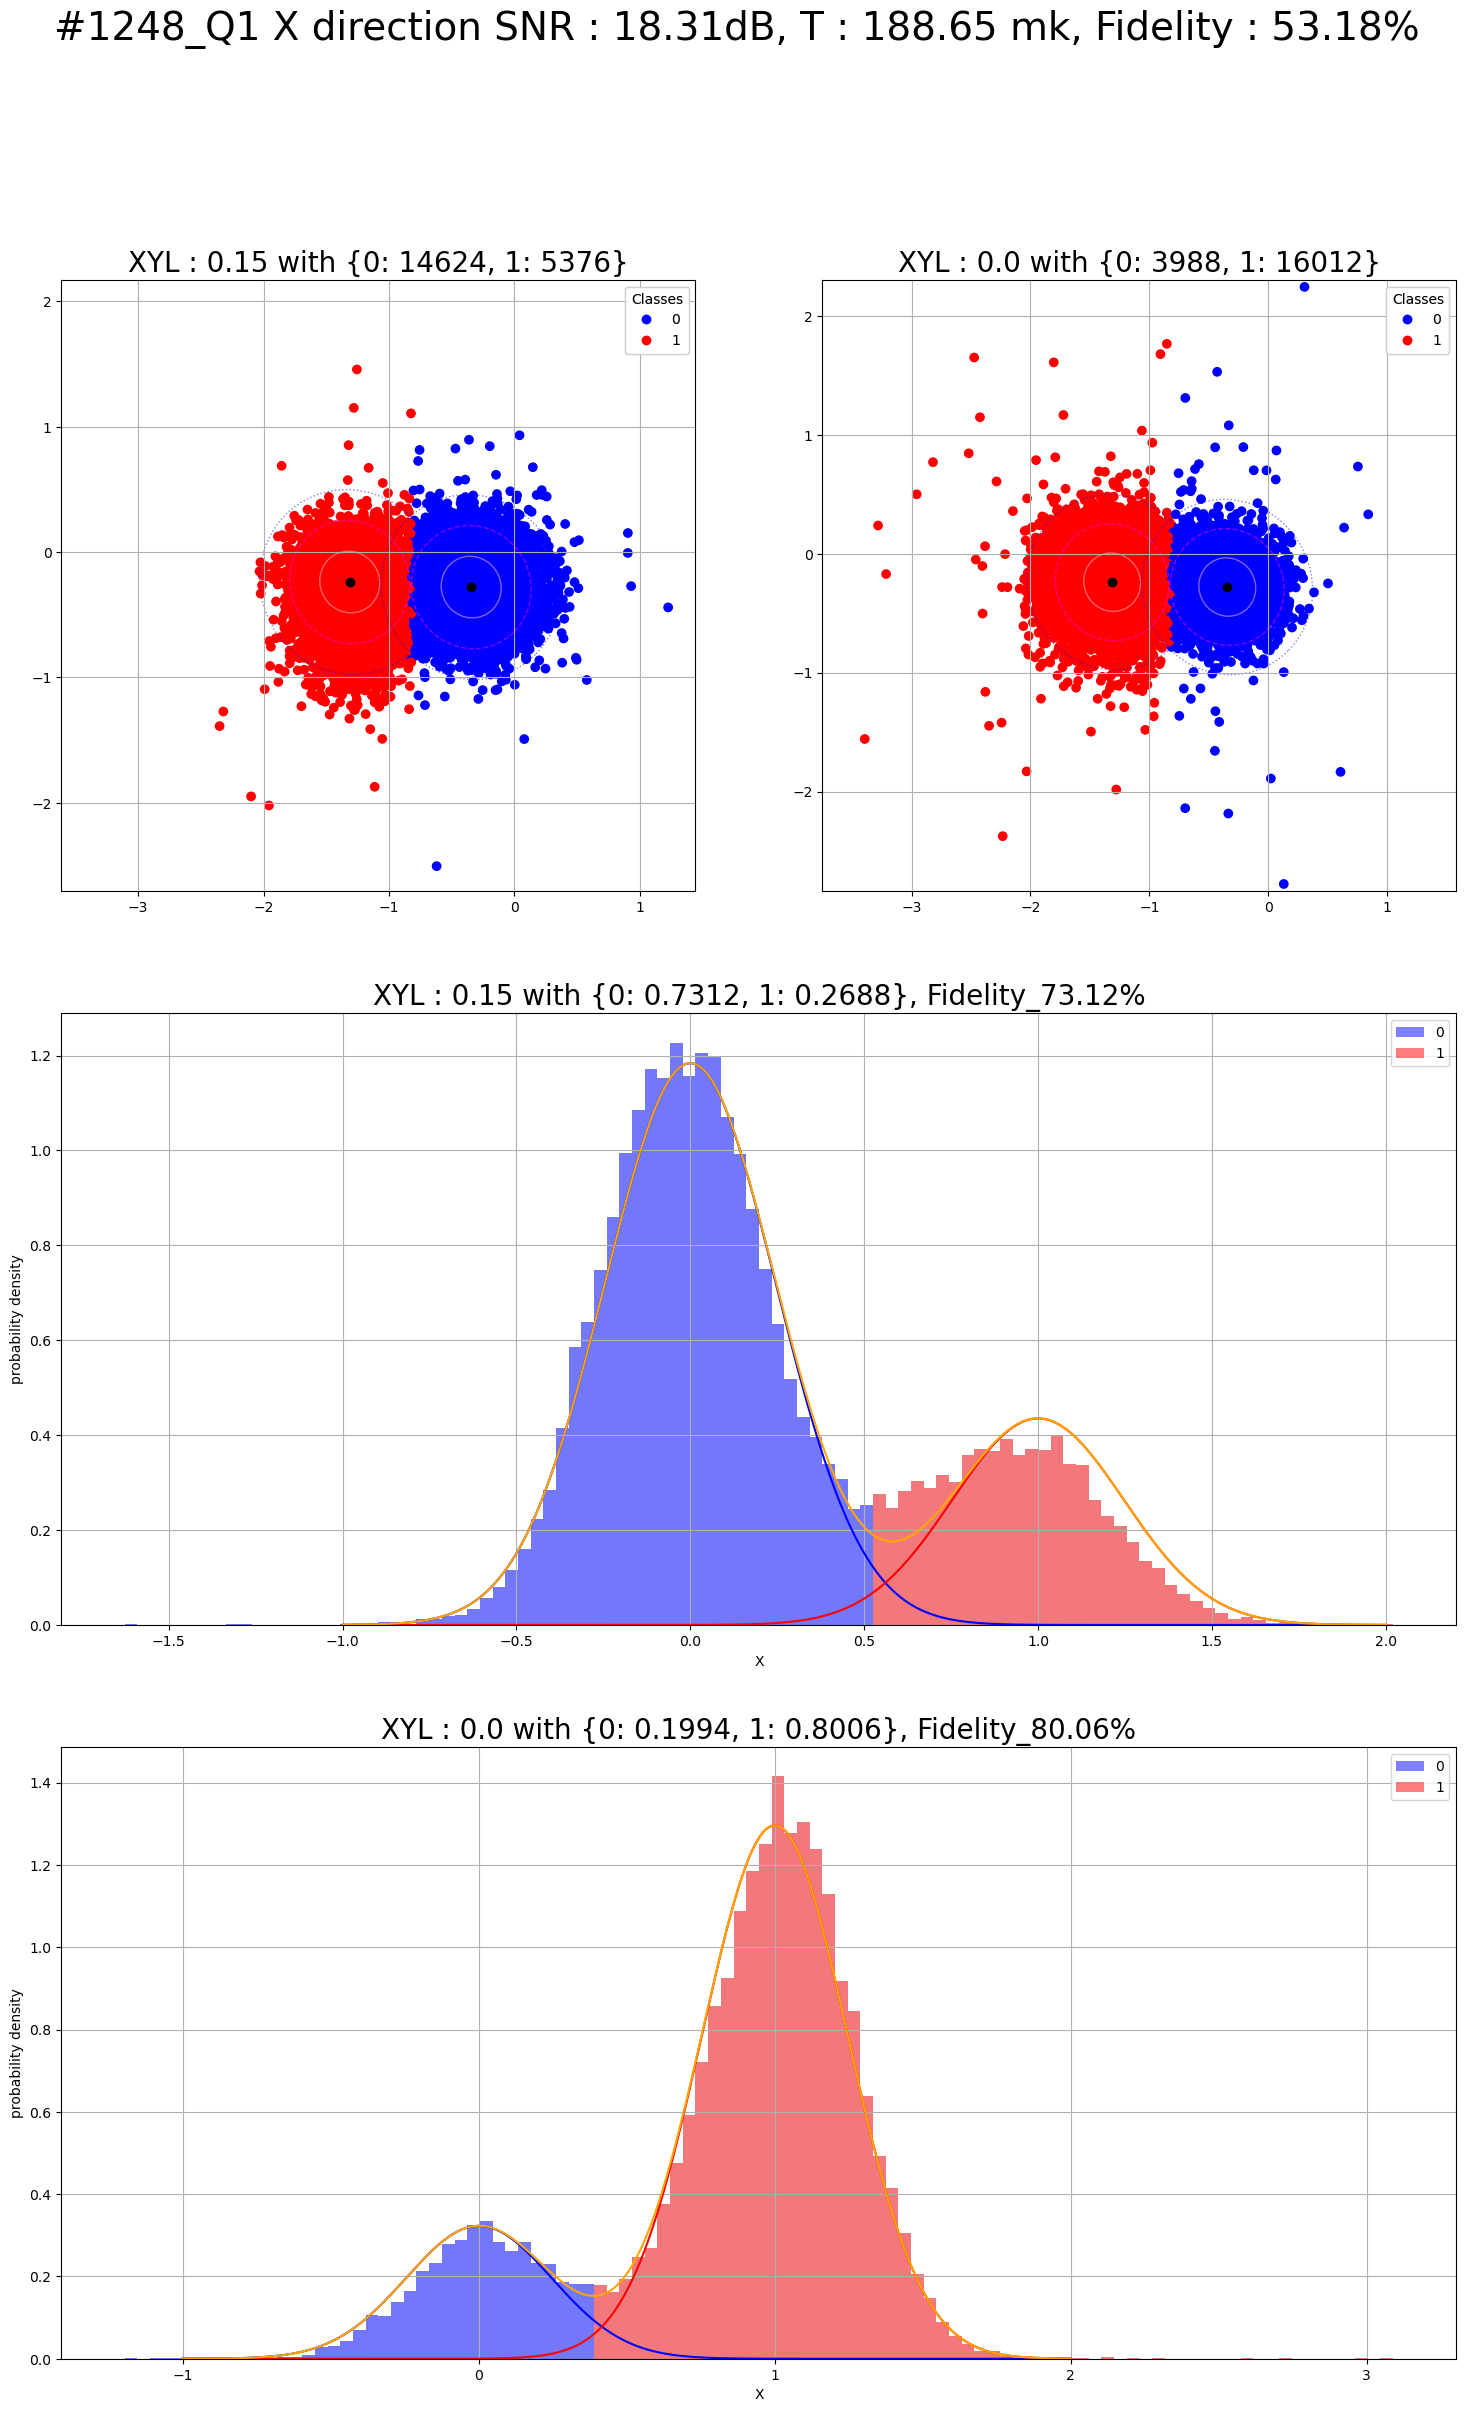

Effective T: 188.65 mK
S :  0.6631783830696882  ; N :  0.08774375528402871  ; SNR :  5.012385968064219


<Figure size 640x480 with 0 Axes>

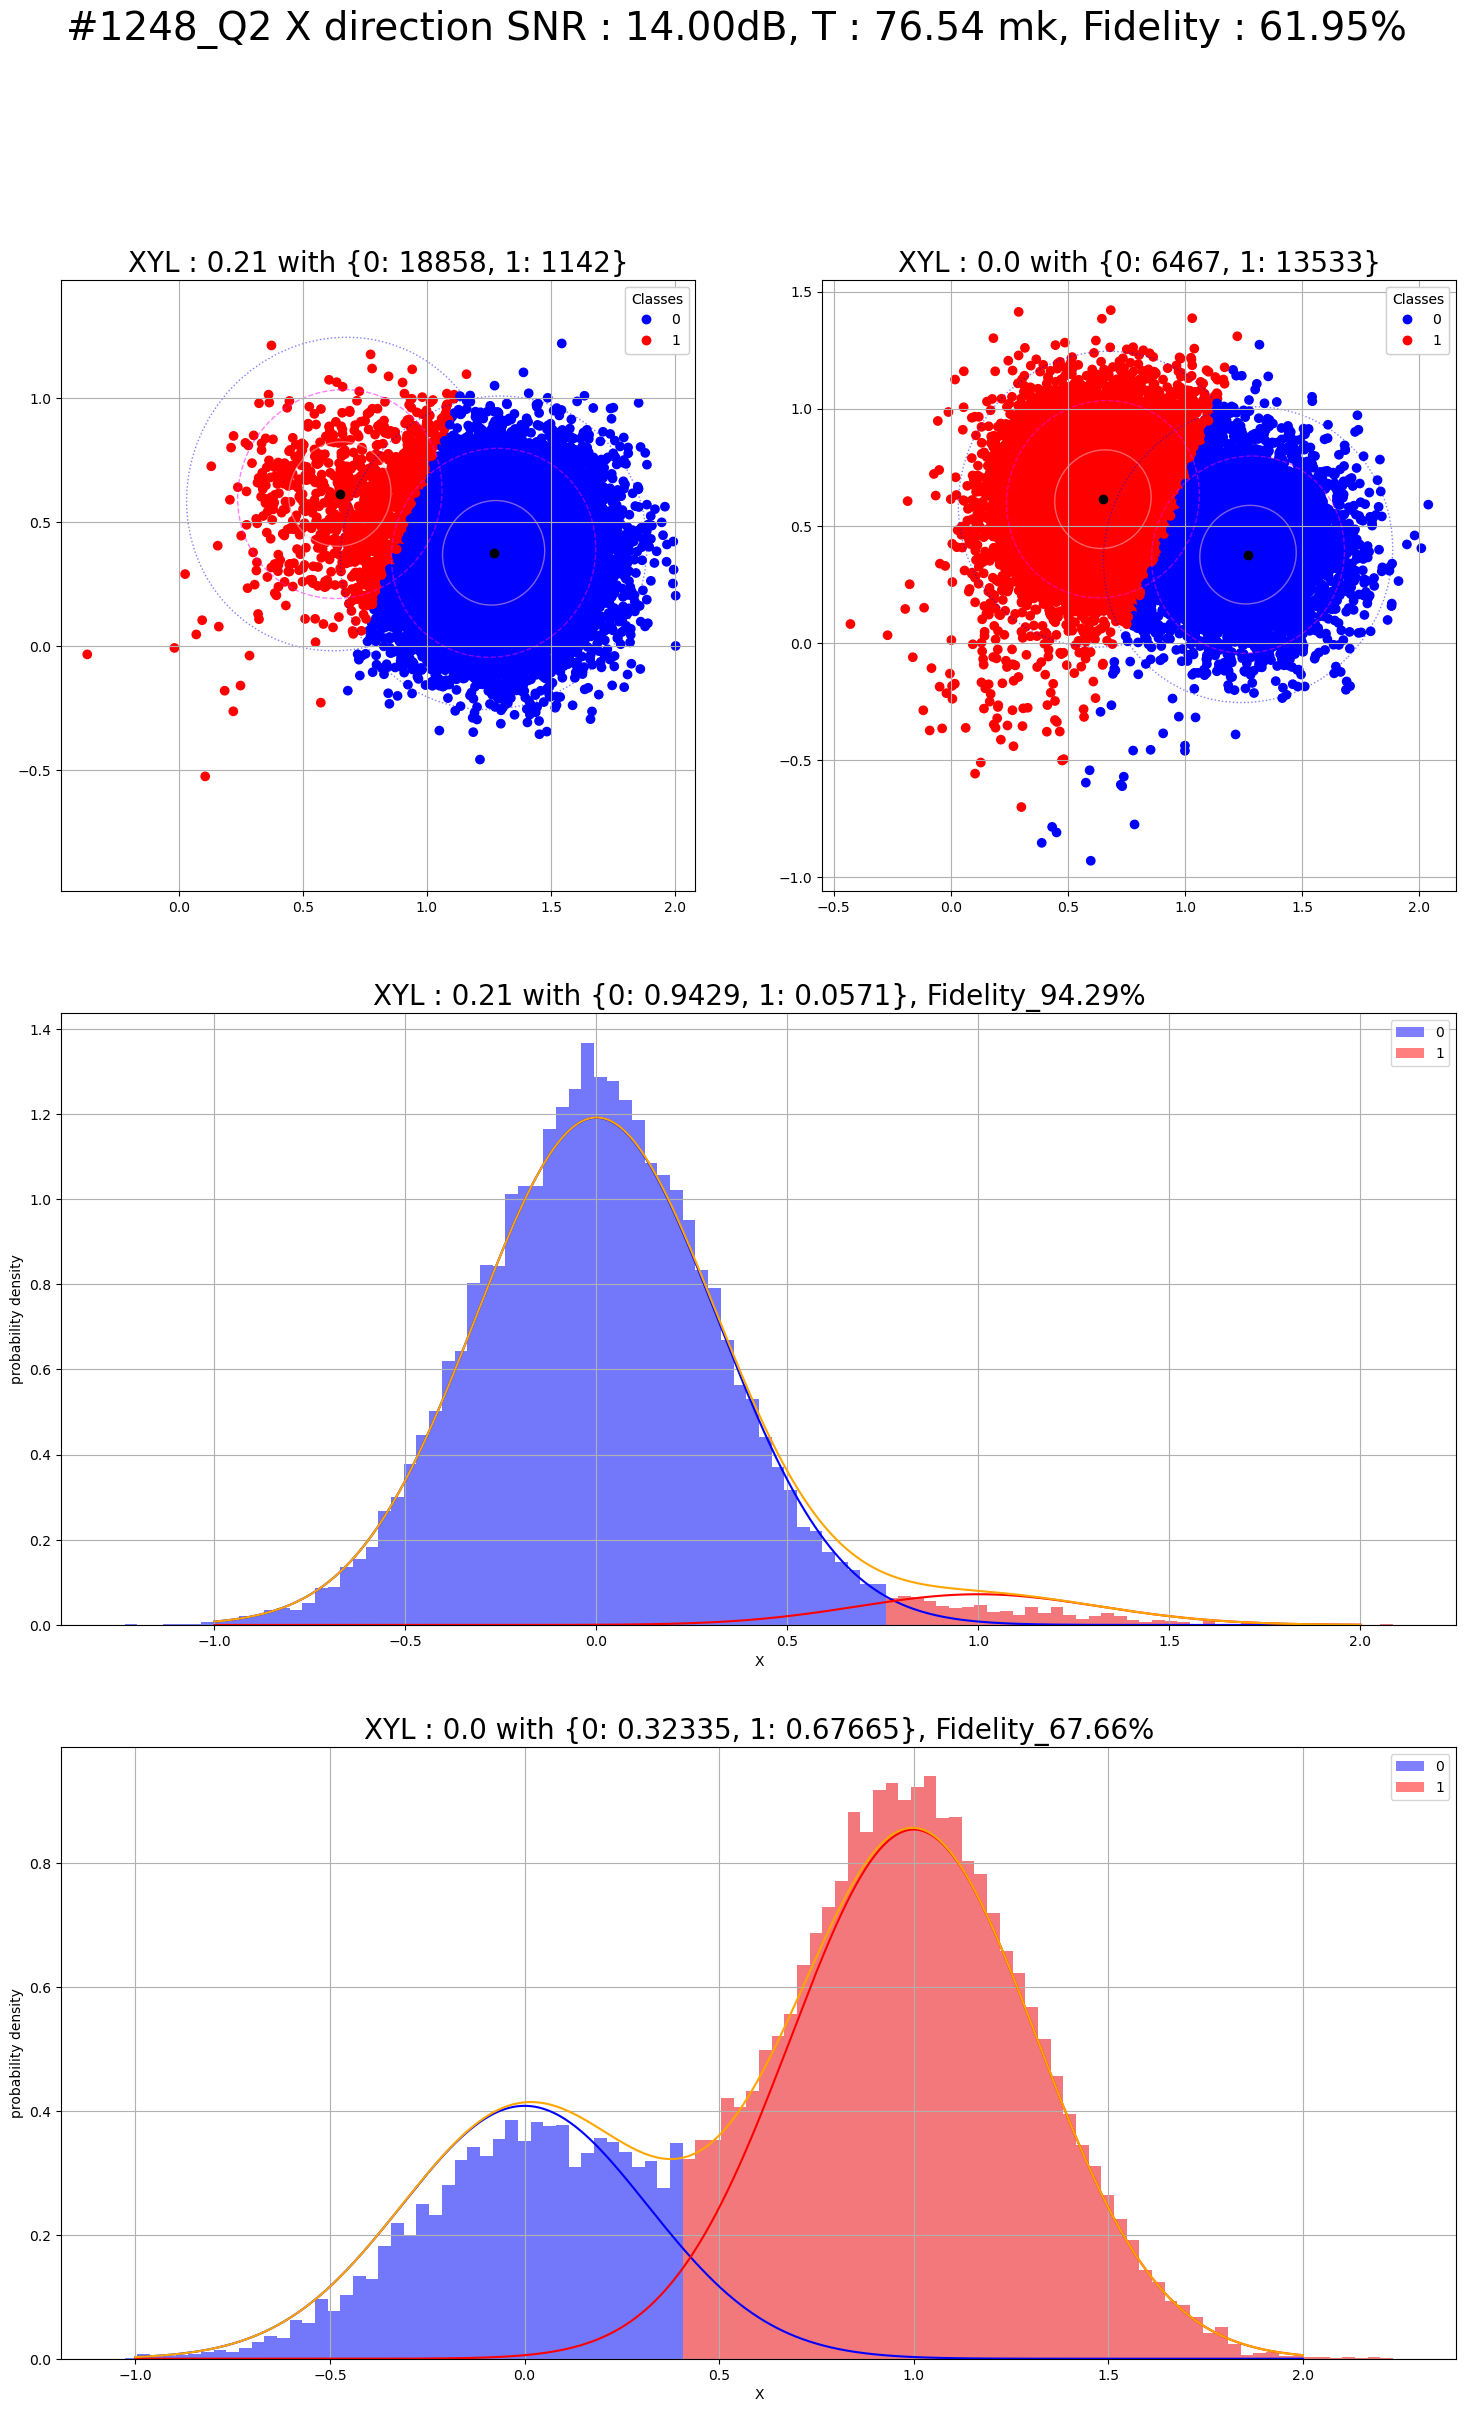

Effective T: 76.54 mK


<Figure size 640x480 with 0 Axes>

In [22]:
Q1Ms = giveGMMandPlot(Q1_zdir,Q1_zdir_g,Q1_zdir_e,fq1,2,True,False,"Q1 X direction","Q1XYL")
Q2Ms = giveGMMandPlot(Q2_zdir,Q2_zdir_g,Q2_zdir_e,fq2,2,True,False,"Q2 X direction","Q2XYL")

In [146]:
Ex = give_probaInfo(Q1Ms,Q2Ms,Q1e,Q2e)
Gr = give_probaInfo(Q1Ms,Q2Ms,Q1g,Q2g)

In [101]:
print(list(Ex)[:2])
print(Gr[:2])

[0.08979999999999827, 0.16999999999998944]
(0.9141999999999075, 0.029000000000000317)


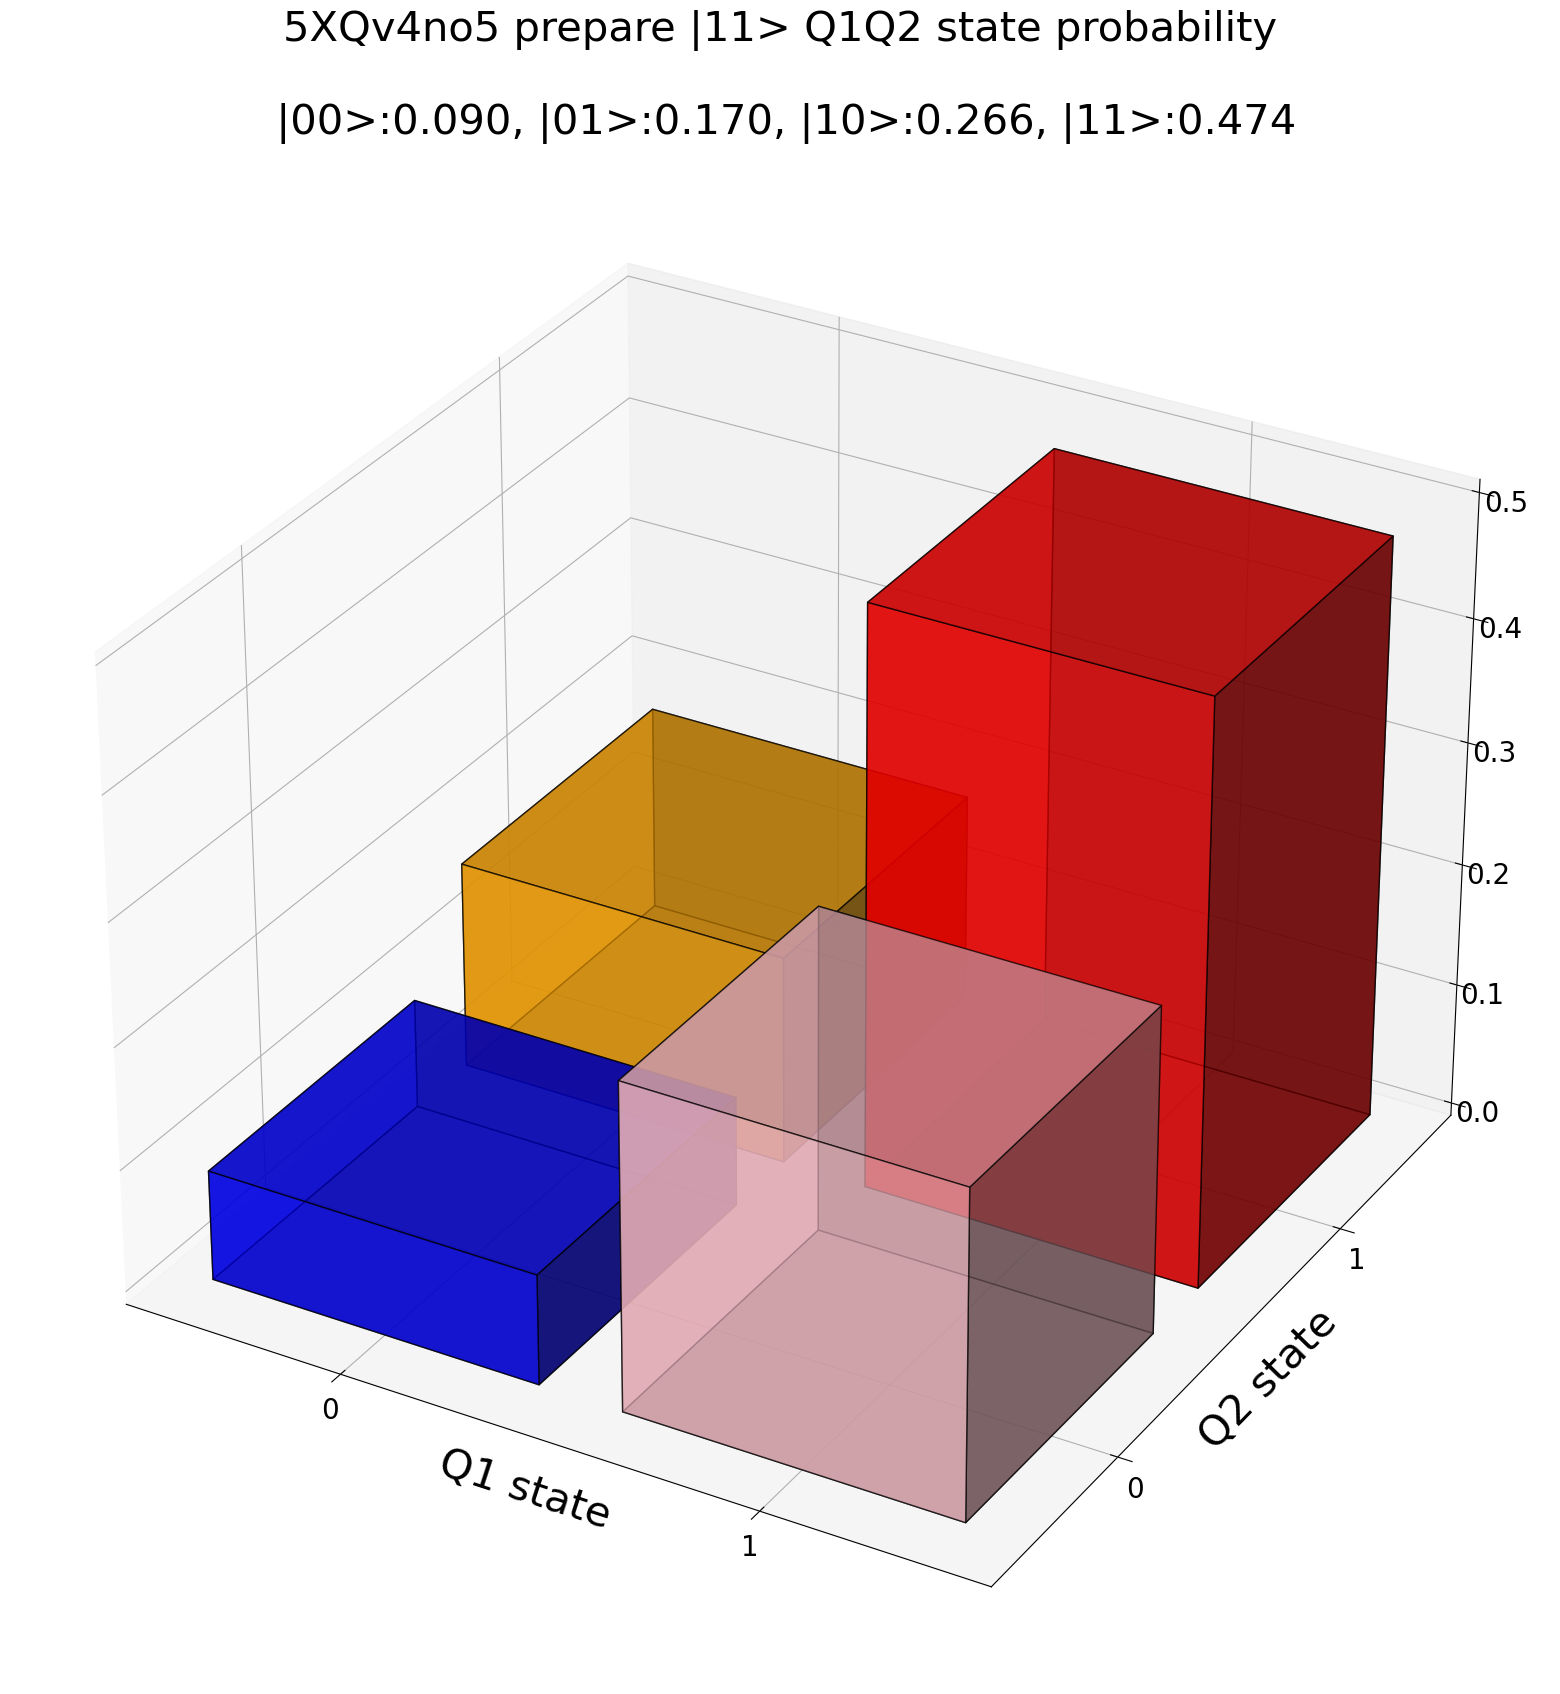

(0.9142, 0.029)


In [189]:
plotProb3DHist(Ex,'5XQv4no5 prepare |11>',False)


In [161]:
print(np.arange(0,1,0.1))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
